In [1]:
def getWeek(index):
    return int(pd.datetime.strftime(index,'%V'))

In [24]:
def comp_dewpoint(df):
    T = df.AT
    RH = df.RH
    
    TD = 243.04*(np.log(RH/100)+((17.625*T)/(243.04+T)))/(17.625-np.log(RH/100)-((17.625*T)/(243.04+T)))
    
    return TD

In [2]:
# set elevations
elevations = {'Vcm':3003.0,'Jemez RAWS':2514.0}

In [3]:
delz = elevations['Vcm'] - elevations['Jemez RAWS']

In [4]:
delz

489.0

In [5]:
lapse = pd.read_pickle('./data/jemez_vcm_lapse_hourly_AT_TD.pcl') # load the monthly lapse rates
jemez = pd.read_pickle('./data/jemez_hourly_RH_TA_2002_2015.pcl') # load the met data
#mod1 = sm.load('./data/rain_duration_model.mod') # load the precip amount, rain duration model

In [25]:
jemez['TD'] = jemez.apply(comp_dewpoint,axis=1)

In [6]:
jemez['week'] = jemez.index.map(getWeek) # compute months

In [20]:
jemez = jemez.loc[jemez.week<53].copy()

In [15]:
## Generate the Vcm_tmin
def gen_at(df):
    m = df['week']
    lr = lapse.loc[m,'AT']
    return (df['AT'] + (delz * lr))

def gen_td(df):
    m = df['week']
    lr = lapse.loc[m,'TD']
    return (df['TD'] + (delz * lr))

In [26]:
jemez['Vcm_at'] = jemez.apply(gen_at,axis=1)
jemez['Vcm_td'] = jemez.apply(gen_td,axis=1)

In [31]:
def compute_vcm_RH(df):
    TD = df.Vcm_td
    T = df.Vcm_at
    
    RH =100*(np.exp((17.625*TD)/(243.04+TD))/np.exp((17.625*T)/(243.04+T)))
        
    return RH

In [32]:
jemez['Vcm_RH'] = jemez.apply(compute_vcm_RH,axis=1)

In [62]:
def compute_Vcm_wet_bulb(df):
    
    '''From Stull [2011] J. Applied Met. and Clim.
    
    Valid at sea level, but this was all I could find to compute Tw without air pressure (not avail.)'''
    
    RH = df.Vcm_RH
    AT = df.Vcm_at
    
    Tw = (AT*np.arctan(0.151977*(RH+8.313659)**0.5)) + np.arctan(AT+RH) - np.arctan(RH-1.676331) + \
    ((0.00391838*(RH))**(3./2.))*np.arctan(0.023101*RH)-4.686035
    
    return Tw

In [57]:
jemez.loc[jemez.Vcm_RH>100.,'Vcm_RH'] = 100.
jemez.loc[jemez.Vcm_RH<0.,'Vcm_RH'] = 0.

In [58]:
jemez['Vcm_Tw'] = jemez.apply(compute_Vcm_wet_bulb,axis=1)

In [59]:
jemez.head()

,AT,RH,time,date,dt,week,Vcm_at,TD,Vcm_td,Vcm_RH,Vcm_Tw
2002-10-01 00:00:00,4.715799,34.515635,0,2002-10-01,2002-10-01 00:00:00,40,3.935860,-9.644148,-8.318377,40.434212,-1.427536
2002-10-01 01:00:00,3.856696,29.731345,1,2002-10-01,2002-10-01 01:00:00,40,3.076757,-12.276658,-10.950887,34.925555,-2.232431
2002-10-01 02:00:00,3.413147,27.100760,2,2002-10-01,2002-10-01 02:00:00,40,2.633208,-13.806289,-12.480518,31.886821,-2.634567
2002-10-01 03:00:00,3.415380,26.803148,3,2002-10-01,2002-10-01 03:00:00,40,2.635441,-13.939740,-12.613969,31.540557,-2.639140
2002-10-01 04:00:00,3.863242,28.858792,4,2002-10-01,2002-10-01 04:00:00,40,3.083303,-12.640667,-11.314896,33.911800,-2.247530


In [60]:
Vcm = pd.DataFrame({'AT':jemez.Vcm_at,'TD':jemez.Vcm_td,'RH':jemez.Vcm_RH,'Tw':jemez.Vcm_Tw})

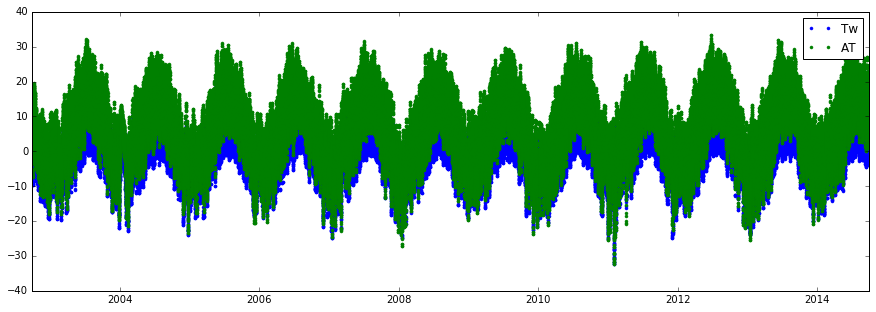

In [65]:
plt.figure(figsize=(15,5))
plt.plot(Vcm.Tw,'.')
plt.plot(Vcm.AT,'.')
plt.legend()

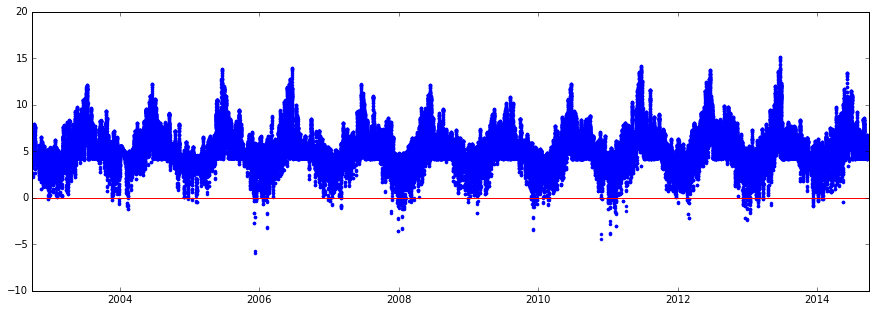

In [68]:
plt.figure(figsize=(15,5))
plt.plot(Vcm.AT-Vcm.Tw,'.')
plt.axhline(0,c='r')

In [70]:
Vcm.to_pickle('./data/vcm_hourly_from_raws.pcl')

In [77]:
Vcm['diff'] = Vcm['AT']-Vcm['Tw']

In [81]:
Vcm

,AT,RH,TD,Tw,diff
2002-10-01 00:00:00,3.935860,40.434212,-8.318377,-1.427536,5.363395
2002-10-01 01:00:00,3.076757,34.925555,-10.950887,-2.232431,5.309188
2002-10-01 02:00:00,2.633208,31.886821,-12.480518,-2.634567,5.267776
2002-10-01 03:00:00,2.635441,31.540557,-12.613969,-2.639140,5.274581
2002-10-01 04:00:00,3.083303,33.911800,-11.314896,-2.247530,5.330833
2002-10-01 05:00:00,3.946274,38.825638,-8.829981,-1.455832,5.402106
2002-10-01 06:00:00,5.165543,45.924977,-5.543043,-0.273403,5.438946
2002-10-01 07:00:00,6.658019,54.703190,-1.824209,1.256308,5.401711
2002-10-01 08:00:00,8.321993,64.545313,2.026141,3.047701,5.274292
2002-10-01 09:00:00,10.044066,74.773500,5.770586,4.978882,5.065185
